In [1]:
using JuMP, Ipopt
using Plots
using NPZ

┌ Info: Precompiling JuMP [4076af6c-e467-56ae-b986-b466b2749572]
└ @ Base loading.jl:1273


In [2]:
hull_points = npzread("Scratch/convex_hull_points.npy")

12×2 Array{Float64,2}:
 376.341  3767.73
 383.363  3754.98
 391.048  3756.27
 391.553  3758.36
 393.08   3765.72
 393.106  3773.38
 391.876  3775.99
 389.422  3778.2 
 388.141  3777.91
 383.079  3776.47
 378.186  3774.68
 376.389  3773.96

In [3]:
x = hull_points[:,1]
y = hull_points[:,2]
md2 = maximum((x.-x').^2 .+ (y.-y').^2)

575.9954223700707

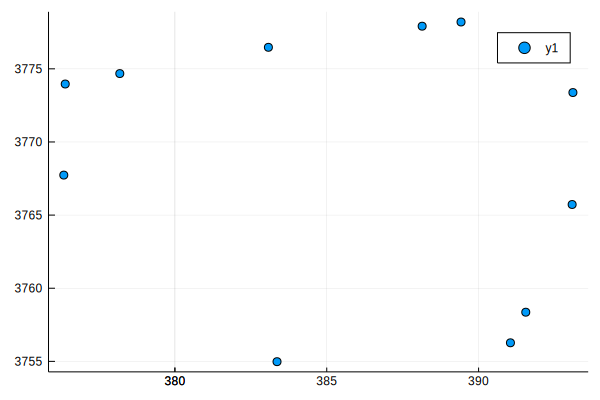

In [4]:
scatter(x,y)

In [52]:
model = Model(with_optimizer(Ipopt.Optimizer))

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt

In [53]:
@variable(model, x1[1:2])
@variable(model, x2[1:2])
@variable(model, x3[1:2])
@variable(model, x4[1:2])
set_start_value.(x1, [minimum(x), minimum(y)])
set_start_value.(x2, [minimum(x), maximum(y)])
set_start_value.(x3, [maximum(x), maximum(y)])
set_start_value.(x4, [maximum(x), minimum(y)])

2-element Array{Nothing,1}:
 nothing
 nothing

In [54]:
#90 degree corners
@constraint(model, (x2-x1)' * (x3-x2) == 0)
@constraint(model, (x3-x2)' * (x4-x3) == 0)
@constraint(model, (x4-x3)' * (x1-x4) == 0)
@constraint(model, (x1-x4)' * (x2-x1) == 0)
# diagonals meet at 90 degrees (for square)
# @constraint(model, (x1-x3)' * (x2-x4) == 0)
# side length ratio (for rectangle)
ratio = 1
@constraint(model, ratio^2*(x1-x2)' * (x1-x2) - (x3-x2)' * (x3-x2) == 0)
@constraint(model, (x1-x3)' * (x1-x3) >= md2) #5% padding for interpolation

x1[1]² - 2 x3[1]*x1[1] + x3[1]² + x1[2]² - 2 x3[2]*x1[2] + x3[2]² ≥ 575.9954223700707

In [55]:
for (xp, yp) in zip(x,y)
    p = [xp, yp]
    @constraint(model,  (x2[1]-x1[1])' * (p[2]-x1[2]) - (x2[2]-x1[2])' * (p[1]-x1[1])  <= -md2*0.1^2) #10% padding
    @constraint(model,  (x3[1]-x2[1])' * (p[2]-x2[2]) - (x3[2]-x2[2])' * (p[1]-x2[1])  <= -md2*0.1^2)
    @constraint(model,  (x4[1]-x3[1])' * (p[2]-x3[2]) - (x4[2]-x3[2])' * (p[1]-x3[1])  <= -md2*0.1^2)
    @constraint(model,  (x1[1]-x4[1])' * (p[2]-x4[2]) - (x1[2]-x4[2])' * (p[1]-x4[1])  <= -md2*0.1^2)
end

In [56]:
@objective(model, Min, (x3-x1)' * (x3-x1))

x3[1]² - 2 x1[1]*x3[1] + x1[1]² + x3[2]² - 2 x1[2]*x3[2] + x1[2]²

In [57]:
optimize!(model)

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       70
Number of nonzeros in inequality constraint Jacobian.:      488
Number of nonzeros in Lagrangian Hessian.............:      198

Total number of variables............................:        8
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:       49
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       48

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [58]:
termination_status(model)

LOCALLY_SOLVED::TerminationStatusCode = 4

In [59]:
objective_value(model)

979.7065131217241

In [60]:
corners = [value.(x1) value.(x2) value.(x3) value.(x4)]
xc = corners[1,:]
yc = corners[2,:]
xcp = [xc; xc[1]]
ycp = [yc; yc[1]]

5-element Array{Float64,1}:
 3752.088802846149 
 3773.3728609223413
 3779.442632612577 
 3758.158574533416 
 3752.088802846149 

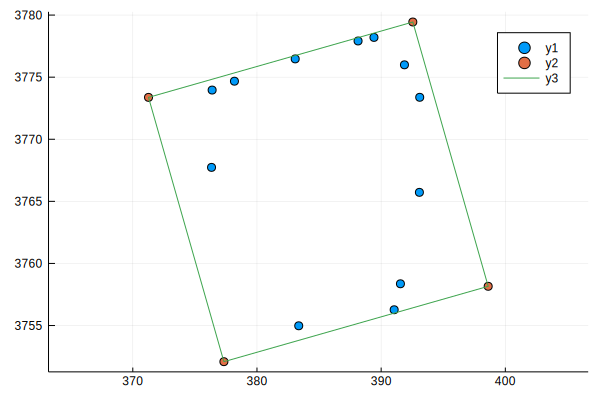

In [61]:
scatter(x,y)
scatter!(corners[1,:], corners[2,:])
plot!(xcp,ycp, aspect_ratio=:equal)

In [62]:
corners

2×4 Array{Float64,2}:
  377.336   371.266   392.55   398.62
 3752.09   3773.37   3779.44  3758.16

In [63]:
sqrt((corners[:,1].-corners[:,2])' * (corners[:,1].-corners[:,2]) / ((corners[:,3].-corners[:,2])' * (corners[:,3].-corners[:,2])))

0.9999999999981881

In [64]:
(corners[:,1].-corners[:,4])' * (corners[:,1].-corners[:,4])

489.85325644239435

In [65]:
npzwrite("Scratch/rectangle_corners.npy", corners)